In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
import pdvega
from natsort import natsort_keygen
from IPython.display import display, HTML
from bigtree import list_to_tree, print_tree, preorder_iter


# for configuring connection 
from configobj import ConfigObj
import os

import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

In [2]:
def connect_to_sql():

    conn_info = {
        "sqluser": 'postgres',
        "sqlpass": 'postgres',
        "sqlhost": 'localhost',
        "sqlport": 5432,
        "dbname": 'eicu',
        "schema_name": 'public,eicu_crd',
    }
    print('Database: {}'.format(conn_info['dbname']))
    print('Username: {}'.format(conn_info["sqluser"]))
    
    con = psycopg2.connect(dbname=conn_info["dbname"],
                           host=conn_info["sqlhost"],
                           port=conn_info["sqlport"],
                           user=conn_info["sqluser"],
                           password=conn_info["sqlpass"])

    query_schema = 'set search_path to ' + conn_info['schema_name'] + ';'
    return con, query_schema

con, query_schema = connect_to_sql()

Database: eicu
Username: postgres


In [3]:
def percentile_print(df):
    print(f"""Percentile analysis:
    \t{'1%: ':<10} {df.quantile(.01)}
    \t{'10%: ':<10} {df.quantile(.1)}
    \t{'25%: ':<10} {df.quantile(.25)}
    \t{'50%: ':<10} {df.quantile(.5)}
    \t{'75%: ':<10} {df.quantile(.75)}
    \t{'90%: ':<10} {df.quantile(.9)}
    \t{'99%: ':<10} {df.quantile(.99)}
    """)

# Patient

In [3]:
query = query_schema + """
select *
from patient
"""

df_info = pd.read_sql_query(query, con)

display(HTML(df_info.head().to_html()))

print(f"""
{'#unique patient:':<20} {df_info['uniquepid'].unique().shape[0]}
{'#unique unit stay:':<20} {df_info['patientunitstayid'].unique().shape[0]}
{'#apache admissiondx:':<20} {df_info[df_info['apacheadmissiondx']!=''].shape[0]} 
{'data completeness - apacheadmissiondx:':<20} {df_info[df_info['apacheadmissiondx']!=''].shape[0] / df_info.shape[0]}
{'discharge status:':<20}
\t{'%Expired:':<15} {df_info[df_info['unitdischargestatus']=='Expired'].shape[0] / df_info.shape[0]} 
\t{'%Alive:':<15} {df_info[df_info['unitdischargestatus']=='Alive'].shape[0] / df_info.shape[0]} 
\t{'%No Record:':<15} {df_info[df_info['unitdischargestatus']==''].shape[0] / df_info.shape[0]} 
""")

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid
0,141168,128919,Female,70,Caucasian,59,91,"Rhythm disturbance (atrial, supraventricular)",152.4,15:54:00,0,Direct Admit,2015,03:50:00,3596,Death,Expired,Med-Surg ICU,15:54:00,Direct Admit,1,admit,84.3,85.8,03:50:00,3596,Death,Expired,002-34851
1,141178,128927,Female,52,Caucasian,60,83,,162.6,08:56:00,-14,Emergency Department,2015,19:20:00,2050,Home,Alive,Med-Surg ICU,09:10:00,Emergency Department,1,admit,54.4,54.4,09:18:00,8,Step-Down Unit (SDU),Alive,002-33870
2,141179,128927,Female,52,Caucasian,60,83,,162.6,08:56:00,-22,Emergency Department,2015,19:20:00,2042,Home,Alive,Med-Surg ICU,09:18:00,ICU to SDU,2,stepdown/other,NaN,60.4,19:20:00,2042,Home,Alive,002-33870
3,141194,128941,Male,68,Caucasian,73,92,"Sepsis, renal/UTI (including bladder)",180.3,18:18:40,-780,Floor,2015,23:30:00,12492,Home,Alive,CTICU,07:18:00,Floor,1,admit,73.9,76.7,15:31:00,4813,Floor,Alive,002-5276
4,141196,128943,Male,71,Caucasian,67,109,,162.6,20:21:00,-99,Emergency Department,2015,17:00:00,5460,Home,Alive,Med-Surg ICU,22:00:00,ICU to SDU,2,stepdown/other,NaN,63.2,22:23:00,1463,Floor,Alive,002-37665



#unique patient:     139367
#unique unit stay:   200859
#apache admissiondx: 177863 
data completeness - apacheadmissiondx: 0.8855117271319682
discharge status:   
	%Expired:       0.05430177388118033 
	%Alive:         0.9455289531462369 
	%No Record:     0.00016927297258275705 



In [4]:
df_info_firstadmit = df_info[df_info['unitstaytype']=='admit']

print(f"""
First ICU admission only, no transfer, no stepdown, no re-admission

{'#unique patient:':<20} {df_info_firstadmit['uniquepid'].unique().shape[0]:>25}
{'#unique unit stay:':<20} {df_info_firstadmit['patientunitstayid'].unique().shape[0]:>25}
{'#apache admissiondx:':<20} {df_info_firstadmit[df_info_firstadmit['apacheadmissiondx']!=''].shape[0]} 
{'data completeness - apacheadmissiondx:':<20} {df_info_firstadmit[df_info_firstadmit['apacheadmissiondx']!=''].shape[0] / df_info_firstadmit.shape[0] * 100}
{'discharge status:':<20}
\t{'%Expired:':<15} {df_info_firstadmit[df_info_firstadmit['unitdischargestatus']=='Expired'].shape[0] / df_info_firstadmit.shape[0] * 100} 
\t{'%Alive:':<15} {df_info_firstadmit[df_info_firstadmit['unitdischargestatus']=='Alive'].shape[0] / df_info_firstadmit.shape[0] * 100} 
\t{'%No Record:':<15} {df_info_firstadmit[df_info_firstadmit['unitdischargestatus']==''].shape[0] / df_info_firstadmit.shape[0] * 100} 
""")



First ICU admission only, no transfer, no stepdown, no re-admission

#unique patient:                        130830
#unique unit stay:                      154948
#apache admissiondx: 152262 
data completeness - apacheadmissiondx: 98.26651521800862
discharge status:   
	%Expired:       5.5986524511449005 
	%Alive:         94.39037612618428 
	%No Record:     0.010971422670831505 



Age distribution:


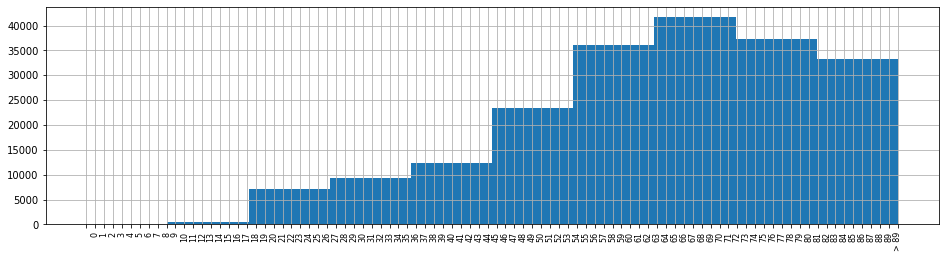

In [5]:
print('Age distribution:')
df_info['age'].sort_values(key=natsort_keygen()).hist(xlabelsize=8, xrot=90, figsize=(16, 4));


Patient Length-Of-Stay:
	min:       -5.3381944444444445
	max:       506.3722222222222
	mean:      2.6792582732165355
Percentile analysis:
	1%:        0.0006944444444444445
	10%:       0.3263888888888889
	25%:       0.81875
	50%:       1.573611111111111
	75%:       2.9715277777777778
	90%:       5.840972222222223
	99%:       19.055847222222212



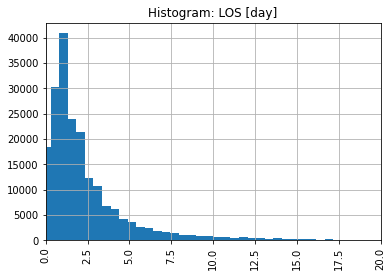

In [6]:
df_los = df_info['unitdischargeoffset'] / 60 / 24
df_los.sort_values()

print(f"""
Patient Length-Of-Stay:
\t{'min: ':<10} {df_los.min()}
\t{'max: ':<10} {df_los.max()}
\t{'mean: ':10} {df_los.mean()}
Percentile analysis:
\t{'1%: ':<10} {df_los.quantile(.01)}
\t{'10%: ':<10} {df_los.quantile(.1)}
\t{'25%: ':<10} {df_los.quantile(.25)}
\t{'50%: ':<10} {df_los.quantile(.5)}
\t{'75%: ':<10} {df_los.quantile(.75)}
\t{'90%: ':<10} {df_los.quantile(.9)}
\t{'99%: ':<10} {df_los.quantile(.99)}
""")

df_los.hist(xrot=90, bins=1000)
plt.xlim(0, 20)
plt.title('Histogram: LOS [day]');

In [7]:
print('Unit stay type:')
df_info.value_counts('unitstaytype').to_frame(name='count')

Unit stay type:


,count
unitstaytype,
admit,154948
stepdown/other,25239
transfer,10725
readmit,9947


In [8]:
print('Unit type:')
df_info.value_counts('unittype').to_frame(name='count')

Unit type:


,count
unittype,
Med-Surg ICU,113222
MICU,17465
CCU-CTICU,15290
Neuro ICU,14451
Cardiac ICU,12467
SICU,12181
CSICU,9625
CTICU,6158


In [9]:
print('Unit admission source:')
df_info.value_counts('unitadmitsource').to_frame(name='count')

Unit admission source:


,count
unitadmitsource,
Emergency Department,89594
Floor,24368
Operating Room,24305
ICU to SDU,13827
Direct Admit,12672
Recovery Room,7844
Acute Care/Floor,5604
Step-Down Unit (SDU),5450
ICU,5439


In [10]:
print('Discharge location:')
df_info.value_counts('unitdischargelocation').to_frame(name='count')

Discharge location:


,count
unitdischargelocation,
Floor,93121
Step-Down Unit (SDU),26945
Acute Care/Floor,20279
Home,18880
Telemetry,10995
Death,10907
Other ICU,6208
Other Hospital,4164
Other External,2789


# Diagnosis

In [11]:
print('Top 50 APACHE admission diagnosis:')
df_info.value_counts('apacheadmissiondx').to_frame(name='count').iloc[:50]

# apache_adm_dx = df[df['apacheadmissiondx']!='']
# apache_adm_dx[['patientunitstayid', 'apacheadmissiondx']]\
#     .groupby('apacheadmissiondx')\
#     .count().sort_values('patientunitstayid', ascending=False).iloc[:30]

Top 50 APACHE admission diagnosis:


,count
apacheadmissiondx,
,22996
"Sepsis, pulmonary",8862
"Infarction, acute myocardial (MI)",7228
"CVA, cerebrovascular accident/stroke",6647
"CHF, congestive heart failure",6617
"Sepsis, renal/UTI (including bladder)",5273
"Rhythm disturbance (atrial, supraventricular)",4827
Diabetic ketoacidosis,4825
Cardiac arrest (with or without respiratory arrest; for respiratory arrest see Respiratory System),4580


In [12]:
query = query_schema + """
select *
from admissiondx
"""

df_admdx = pd.read_sql_query(query, con)

display(HTML(df_admdx.head().to_html()))

print(f"""
{'#unique unit stay:':<30} {df_admdx['patientunitstayid'].unique().shape[0]}
{'#admissiondx:':<30} {df_admdx['admissiondxid'].unique().shape[0]} 
{'#admissiondx per patient:':<30} {df_admdx['admissiondxid'].unique().shape[0] / df_admdx['patientunitstayid'].unique().shape[0]}
""")

,admissiondxid,patientunitstayid,admitdxenteredoffset,admitdxpath,admitdxname,admitdxtext
0,8023778,2900217,62,admission diagnosis|Operative Organ Systems|Organ System|Cardiovascular,Cardiovascular,Cardiovascular
1,8023777,2900217,62,admission diagnosis|Was the patient admitted from the O.R. or went to the O.R. within 4 hours of admission?|Yes,Yes,Yes
2,8023779,2900217,62,admission diagnosis|All Diagnosis|Operative|Diagnosis|Cardiovascular|Aortic and Mitral valve replacement,Aortic and Mitral valve replacement,Aortic and Mitral valve replacement
3,7929318,2900240,53,admission diagnosis|Non-operative Organ Systems|Organ System|Gastrointestinal,Gastrointestinal,Gastrointestinal
4,7929317,2900240,53,admission diagnosis|Was the patient admitted from the O.R. or went to the O.R. within 4 hours of admission?|No,No,No



#unique unit stay:             177863
#admissiondx:                  626858 
#admissiondx per patient:      3.5243867471031076



In [13]:
dx = list(df_admdx['admitdxpath'].unique())

tr_dx = list_to_tree(dx, sep='|')
print(f"Max depth: {tr_dx.max_depth}")

nodes_deep = {i: [] for i in range(1, tr_dx.max_depth+1)}

for node in preorder_iter(tr_dx.root):
    nodes_deep[node.depth].append(node.path_name)

Max depth: 6


In [14]:
print_tree(tr_dx, max_depth=3)

admission diagnosis
├── Operative Organ Systems
│   └── Organ System
├── Was the patient admitted from the O.R. or went to the O.R. within 4 hours of admission?
│   ├── Yes
│   └── No
├── All Diagnosis
│   ├── Operative
│   └── Non-operative
├── Non-operative Organ Systems
│   └── Organ System
├── Additional APACHE  Information
│   ├── Acute MI location
│   ├── Thrombolytic Therapy received within 24 hours
│   ├── Saphenous vein graft?
│   ├── Pre-op ejection fraction (%)
│   ├── Internal mammary artery graft?
│   ├── Pre-op MI during current hospitalization
│   ├── Pre-op cardiac catheterization during this hospitalization
│   ├── Number of grafts performed
│   └── PTCA done within 24 hours
├── Elective
│   ├── No
│   └── Yes
└── Patient transferred from another hospital to the current hospital within 48 hours prior to ICU admission
    └── Patient transferred from another hospital to the current hospital within 48 hours prior to ICU admission


# check tables: treatment, respiratorycare, repiratorycharting

# Treatment

- treatmentid: unique id for each treatment entry
- patientunitstayid
- treatmentoffset
- treatmentstring: exact treatment in tree structure
- activeupondischarge: is the treatment still active when the patient is discharged

In [4]:
query = query_schema + """
select *
from treatment
"""

df_tr = pd.read_sql_query(query, con)
df_tr.shape

(3688745, 5)

Percentile analysis:
    	1%:        7.0
    	10%:       54.0
    	25%:       275.0
    	50%:       2083.0
    	75%:       6900.0
    	90%:       16376.0
    	99%:       56223.0
    


Text(0.5, 0, 'treatment offset [day]')

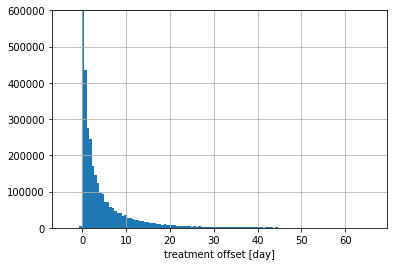

In [18]:
percentile_print(df_tr['treatmentoffset'])
(df_tr['treatmentoffset']/60/24).hist(bins=1000)
plt.ylim(0, 6e5)
plt.xlim(-1e4/60/24, 1e5/60/24);
plt.xlabel('treatment offset [day]')


Number of patients with treatment:
	152429
Number of treatments per patient
	min:       1
	max:       7743
	mean:      24.199758576123966
Percentile analysis:
	1%:        1.0
	10%:       1.0
	25%:       2.0
	50%:       6.0
	75%:       18.0
	90%:       51.0
	99%:       299.0



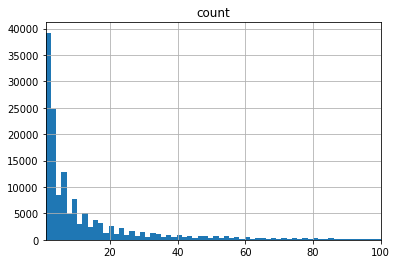

In [5]:
tr_per_pat = df_tr.value_counts('patientunitstayid').to_frame(name='count')

print(f"""
Number of patients with treatment:
\t{df_tr['patientunitstayid'].unique().shape[0]}
Number of treatments per patient
\t{'min: ':<10} {tr_per_pat['count'].min()}
\t{'max: ':<10} {tr_per_pat['count'].max()}
\t{'mean: ':10} {tr_per_pat['count'].mean()}
Percentile analysis:
\t{'1%: ':<10} {tr_per_pat['count'].quantile(.01)}
\t{'10%: ':<10} {tr_per_pat['count'].quantile(.1)}
\t{'25%: ':<10} {tr_per_pat['count'].quantile(.25)}
\t{'50%: ':<10} {tr_per_pat['count'].quantile(.5)}
\t{'75%: ':<10} {tr_per_pat['count'].quantile(.75)}
\t{'90%: ':<10} {tr_per_pat['count'].quantile(.9)}
\t{'99%: ':<10} {tr_per_pat['count'].quantile(.99)}
""")
tr_per_pat.hist(bins=5000)
plt.xlim(1, 100);

In [6]:
treatments = df_tr['treatmentstring'].unique()
print(f"""
Unique treatment IDs: {df_tr['treatmentid'].unique().shape[0]}
Unique treament: {treatments.shape[0]}
""")

treatments = ['treatment|'+t for t in treatments]
tr_treatments = list_to_tree(treatments, sep='|')
print(f"Max depth: {tr_treatments.max_depth}")

nodes_deep = {i: [] for i in range(1,8)}

for node in preorder_iter(tr_treatments.root):
    nodes_deep[node.depth].append(node.path_name)
    
nodes_deep[2]


Unique treatment IDs: 3688745
Unique treament: 2711

Max depth: 7


['|treatment|cardiovascular',
 '|treatment|infectious diseases',
 '|treatment|pulmonary',
 '|treatment|surgery',
 '|treatment|endocrine',
 '|treatment|gastrointestinal',
 '|treatment|neurologic',
 '|treatment|renal',
 '|treatment|transplant',
 '|treatment|general',
 '|treatment|hematology',
 '|treatment|toxicology',
 '|treatment|burns/trauma',
 '|treatment|oncology']

In [8]:
print("Sub tree plot: treatment for cardiovascular cases")
print_tree(tr_treatments,  node_name_or_path="cardiovascular", max_depth=3)

Sub tree plot: treatment for cardiovascular cases
cardiovascular
├── hypertension
│   ├── angiotensin II receptor blocker (ARB)
│   ├── ACE inhibitor
│   ├── beta blocker
│   ├── clonidine
│   ├── vasodilating agent - IV
│   ├── antihypertensive combination agent
│   ├── calcium channel blocker
│   ├── alpha/beta blocker
│   ├── analgesics
│   ├── sedative agent
│   └── minoxidil
├── myocardial ischemia / infarction
│   ├── antihyperlipidemic agent
│   ├── anticoagulant administration
│   ├── antiplatelet agent
│   ├── beta blocker
│   ├── nitroglycerin
│   ├── glycoprotein IIB/IIIA inhibitor
│   ├── alpha/beta blocker
│   ├── angiotensin II receptor blocker (ARB)
│   ├── ACE inhibitor
│   ├── thrombolytic therapy
│   ├── analgesics
│   ├── inotropic agent
│   └── calcium channel blocker
├── non-operative procedures
│   ├── diagnostic ultrasound of heart
│   ├── cardiac angiography
│   ├── implantation of heart pacemaker
│   ├── external pacemaker
│   ├── cardioversion
│   ├── AICD pla

# Respiratory Care

- respcareid
- patientunitstayid
- respcarestatusoffset

In [139]:
query = query_schema + """
select *
from respiratorycare
"""

df = pd.read_sql_query(query, con)
df.shape
df.head()

,respcareid,patientunitstayid,respcarestatusoffset,currenthistoryseqnum,airwaytype,airwaysize,airwayposition,cuffpressure,ventstartoffset,ventendoffset,...,peeplimit,cpaplimit,setapneainterval,setapneatv,setapneaippeephigh,setapnearr,setapneapeakflow,setapneainsptime,setapneaie,setapneafio2
0,555232,141168,1926,1,,,,NaN,1566,0,...,NaN,NaN,,,,,,,,
1,550536,141227,1567,1,,,,NaN,1267,0,...,NaN,NaN,,,,,,,,
2,558282,141233,1618,2,,,,NaN,0,0,...,NaN,NaN,,,,,,,,
3,558281,141233,5,1,,,,NaN,-298,0,...,NaN,NaN,,,,,,,,
4,559466,141276,228,2,,,,NaN,0,0,...,NaN,NaN,,,,,,,,


In [76]:
display(HTML(df.iloc[:30].to_html()))

,respcareid,patientunitstayid,respcarestatusoffset,currenthistoryseqnum,airwaytype,airwaysize,airwayposition,cuffpressure,ventstartoffset,ventendoffset,priorventstartoffset,priorventendoffset,apneaparams,lowexhmvlimit,hiexhmvlimit,lowexhtvlimit,hipeakpreslimit,lowpeakpreslimit,hirespratelimit,lowrespratelimit,sighpreslimit,lowironoxlimit,highironoxlimit,meanairwaypreslimit,peeplimit,cpaplimit,setapneainterval,setapneatv,setapneaippeephigh,setapnearr,setapneapeakflow,setapneainsptime,setapneaie,setapneafio2
0,555232,141168,1926,1,,,,NaN,1566,0,0,0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,
1,550536,141227,1567,1,,,,NaN,1267,0,0,0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,
2,558282,141233,1618,2,,,,NaN,0,0,-298,1317,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,
3,558281,141233,5,1,,,,NaN,-298,0,0,0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,
4,559466,141276,228,2,,,,NaN,0,0,-302,-72,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,
5,559465,141276,-2,1,,,,NaN,-302,0,0,0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,
6,564408,141289,280,1,,,,NaN,-20,0,0,0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,
7,559301,141314,40,1,,,,NaN,-260,0,0,0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,
8,562477,141436,-112,1,,,,NaN,-412,0,0,0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,
9,562478,141436,1928,2,,,,NaN,0,0,-412,1855,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,


In [77]:
query = query_schema + """
select *
from respiratorycharting
"""

df = pd.read_sql_query(query, con)

In [78]:
display(HTML(df.iloc[:30].to_html()))

,respchartid,patientunitstayid,respchartoffset,respchartentryoffset,respcharttypecat,respchartvaluelabel,respchartvalue
0,3,221468,4679,4679,respFlowCareData,RT Vent On/Off,Continued
1,4,221468,4679,4679,respFlowSettings,FiO2,40
2,5,221468,4679,4679,respFlowSettings,Vent Rate,14
3,6,221468,4679,4679,respFlowSettings,Tidal Volume (set),450
4,7,221468,4679,4679,respFlowSettings,TV/kg IBW,5.4720
5,8,221468,4679,4679,respFlowCareData,Tidal Volume Observed (VT),504
6,9,221468,4679,4679,respFlowSettings,PEEP,8
7,10,221468,4679,4679,respFlowPtVentData,Plateau Pressure,18
8,39,143209,497,497,respFlowCareData,Tidal Volume Observed (VT),520
9,40,143209,497,497,respFlowSettings,Pressure Support,12


In [79]:
df.shape

(20168176, 7)

# Admission Drug

In [20]:
query = query_schema + """
select *
from admissiondrug
"""

df_admdrug = pd.read_sql_query(query, con)
# print(df.shape)
df_admdrug.head()

,admissiondrugid,patientunitstayid,drugoffset,drugenteredoffset,drugnotetype,specialtytype,usertype,rxincluded,writtenineicu,drugname,drugdosage,drugunit,drugadmitfrequency,drughiclseqno
0,1589228,242954,64,79,Admission,eCM Primary,THC Nurse,True,True,ELIQUIS ...,0.0,,,37792
1,2063596,243285,29,39,Admission,eCM Primary,THC Nurse,False,True,VICTOZA 2-PAK ...,0.0,,,36436
2,2063595,243285,29,39,Admission,eCM Primary,THC Nurse,False,True,POTASSIUM CHLORIDE ...,0.0,,,549
3,2063590,243285,29,39,Admission,eCM Primary,THC Nurse,False,True,CITALOPRAM HBR ...,0.0,,,10321
4,2063594,243285,29,39,Admission,eCM Primary,THC Nurse,False,True,OMEPRAZOLE ...,0.0,,,4673


In [23]:
print(f"""
{'#patient unit stays: ':<25} {df_admdrug['patientunitstayid'].unique().shape[0]}
{'#admission drug entries: ':<25} {df_admdrug['admissiondrugid'].unique().shape[0]}
{'#drug types: ':<25} {df_admdrug['drugname'].unique().shape[0]}
""")
print('drug note types:')
df_count = df_admdrug['drugnotetype'].value_counts()
for typ in df_count.index:
    print(f"\t{typ:<30}: {df_count.loc[typ]}")
print('specialty types:')
df_count = df_admdrug['specialtytype'].value_counts()
for typ in df_count.index:
    print(f"\t{typ:<30}: {df_count.loc[typ]}")


#patient unit stays:      40740
#admission drug entries:  874920
#drug types:              4417

drug note types:
	Comprehensive Progress        : 518159
	Admission                     : 314537
	Re-Admission                  : 21502
	Daily Progress                : 11684
	Follow-up Consultation/Other  : 6155
	Initial Consultation/Other    : 2883
specialty types:
	eCM Primary                   : 865882
	critical care medicine (CCM)  : 7134
	neurology                     : 1323
	pulmonary/CCM                 : 224
	pulmonary                     : 128
	infectious disease            : 92
	surgery-trauma                : 44
	hospitalist                   : 31
	nephrology                    : 24
	surgery-neuro                 : 24
	gastroenterology              : 8
	pharmacist                    : 4
	allergy/immunology            : 2


In [52]:
pid_adm = set(df_admdrug.loc[df_admdrug['drugnotetype']=='Admission', 'patientunitstayid'])
print(f"{'#patient stay - First admission:':<50} {len(pid_adm)}")

for typ in df_admdrug['drugnotetype'].unique():
    if typ == 'Admission':
        continue
    pid_ = set(df_admdrug.loc[df_admdrug['drugnotetype']==typ, 'patientunitstayid'])
    print(f"{'#patient stay - '+typ+':':<50} {len(pid_):<10}, {'intersection with first admission: ':} {len(pid_adm.intersection(pid_))}")



#patient stay - First admission:                   36902
#patient stay - Re-Admission:                      2302      , intersection with first admission:  0
#patient stay - Daily Progress:                    737       , intersection with first admission:  608
#patient stay - Comprehensive Progress:            13637     , intersection with first admission:  11448
#patient stay - Follow-up Consultation/Other:      271       , intersection with first admission:  205
#patient stay - Initial Consultation/Other:        397       , intersection with first admission:  282


drug administration time:
Percentile analysis:
    	1%:        -157.0
    	10%:       7.0
    	25%:       49.0
    	50%:       1088.0
    	75%:       5302.0
    	90%:       14941.0
    	99%:       260054.0
    


(0.0, 100000.0)

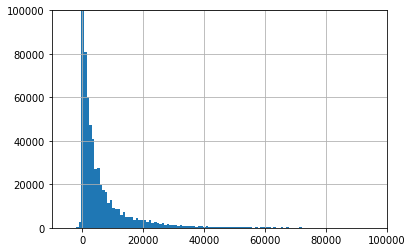

In [28]:
print('drug administration time:')
percentile_print(df_admdrug['drugoffset'])
df_admdrug['drugoffset'].hist(bins = 1000)
plt.xlim(-1e4, 1e5)
plt.ylim(0, 1e5)

In [53]:
# WHAT IS RXINCLUDED???
print('Repeatitive administration of the admission drug')
df_admdrug.loc[(df_admdrug['patientunitstayid']==255112)&(df_admdrug['drughiclseqno']==743)].sort_values('drugoffset')

Repeatitive administration of the admission drug


,admissiondrugid,patientunitstayid,drugoffset,drugenteredoffset,drugnotetype,specialtytype,usertype,rxincluded,writtenineicu,drugname,drugdosage,drugunit,drugadmitfrequency,drughiclseqno
143,1654456,255112,1,85,Admission,eCM Primary,THC Nurse,True,True,ZINC GLUCONATE ...,0.0,,,743
137,1523676,255112,2805,2816,Comprehensive Progress,eCM Primary,THC Nurse,True,True,ZINC GLUCONATE ...,0.0,,,743
136,1897374,255112,5155,5158,Comprehensive Progress,eCM Primary,THC Nurse,False,True,ZINC GLUCONATE ...,0.0,,,743
106,2129826,255112,5890,7337,Comprehensive Progress,eCM Primary,THC Nurse,False,True,ZINC GLUCONATE ...,0.0,,,743
103,2144973,255112,10274,10276,Comprehensive Progress,eCM Primary,THC Nurse,True,True,ZINC GLUCONATE ...,0.0,,,743
142,1934272,255112,11082,11087,Comprehensive Progress,eCM Primary,THC Nurse,False,True,ZINC GLUCONATE ...,0.0,,,743


In [54]:
print('Admission and discharge time of this patient')
display(HTML(df_info[df_info['patientunitstayid']==255112][['hospitaladmitoffset', 'hospitaldischargeoffset', 'unitdischargeoffset']].to_html()))

Admission and discharge time of this patient


,hospitaladmitoffset,hospitaldischargeoffset,unitdischargeoffset
15522,-2,15454,15463


In [57]:
print('Most frequently used admission drug:')
check = df_admdrug['drugname'].value_counts(ascending=False).to_frame(name='count')
check.iloc[:30]

Most frequently used admission drug:


,count
ASPIRIN,29175
LISINOPRIL,19003
LASIX,15758
OMEPRAZOLE,12646
ALBUTEROL,10525
LEVOTHYROXINE SODIUM,9933
SIMVASTATIN,9125
GABAPENTIN,8902
MULTIVITAMIN,8890
LANTUS,8787


#  Grouping script of medication perscription from eICU

In [58]:
file_pivot_med = '/home/kai/DigitalICU/Dataset/EICU/eicu-code/concepts/pivoted/pivoted-med.sql'
sql_file = open(file_pivot_med, 'r')

cursor = con.cursor()
cursor.execute(sql_file.read())

In [59]:
query = query_schema + """
select *
from pivoted_med
"""

df_pmed = pd.read_sql_query(query, con)
print(df_pmed.shape)
df_pmed.head()

(5167365, 13)


,patientunitstayid,drugorderoffset,chartoffset,drugstopoffset,norepinephrine,epinephrine,dopamine,dobutamine,phenylephrine,vasopressin,milrinone,heparin,warfarin
0,141168,111.0,51,2050.0,0,0,0,0,0,0,0,0,0
1,141168,112.0,126,152.0,0,0,0,0,0,0,0,0,0
2,141168,112.0,126,1466.0,0,0,0,0,0,0,0,0,0
3,141168,117.0,246,1721.0,0,0,0,0,0,0,0,0,0
4,141168,470.0,471,513.0,0,0,0,0,0,0,0,0,0


In [62]:
col_med = df_pmed.columns[4:]
for col in col_med:
    print(f"{col+':':<20} {df_pmed[df_pmed[col]!=0].shape[0]}")

norepinephrine:      31352
epinephrine:         9968
dopamine:            6243
dobutamine:          4282
phenylephrine:       17248
vasopressin:         6274
milrinone:           2256
heparin:             95667
warfarin:            59145


# Medication prescription

In [64]:
query = query_schema + """
select *
from medication
"""

df_med = pd.read_sql_query(query, con)
print(df_med.shape)
df_med.head()

(7301853, 15)


,medicationid,patientunitstayid,drugorderoffset,drugstartoffset,drugivadmixture,drugordercancelled,drugname,drughiclseqno,dosage,routeadmin,frequency,loadingdose,prn,drugstopoffset,gtc
0,7426715,141168,309,666,No,No,METOPROLOL TARTRATE 25 MG PO TABS,2102.0,25 3,PO,Q12H SCH,,No,1826,0
1,9643232,141168,1847,1832,No,No,3 ML - IPRATROPIUM-ALBUTEROL 0.5-2.5 (3) MG/...,NaN,3 1,NEBULIZATION,Q4H Resp PRN,,Yes,2047,0
2,10270090,141168,296,1386,No,No,ASPIRIN EC 81 MG PO TBEC,1820.0,81 3,PO,Daily,,No,2390,0
3,9496768,141168,2048,2029,No,No,3 ML - IPRATROPIUM-ALBUTEROL 0.5-2.5 (3) MG/...,NaN,3 1,NEBULIZATION,Q4H Resp PRN,,Yes,2390,0
4,11259680,141168,117,246,No,No,ENOXAPARIN SODIUM 40 MG/0.4ML SC SOLN,NaN,40 3,SC,Daily,,No,1721,0


In [66]:
df_norepinephrine = df_med.loc[((df_med['drughiclseqno'].isin([37410, 36346, 2051]))
                               |(df_med['drugname'].str.contains('norepinephrine',na=False, case=False)))
                               &(df_med['drugordercancelled']=='No')
                               &(df_med['prn']=='No')
                              ]
df_norepinephrine.shape

print(f"""
Perscription of norepinephrine:

{'#medication ids:':<20} {df_norepinephrine['medicationid'].unique().shape[0]} 
{'#unique unit stay:':<20} {df_norepinephrine['patientunitstayid'].unique().shape[0]}
{'#patient:':<20} {df_info.loc[df_info['patientunitstayid'].isin(df_norepinephrine['patientunitstayid']), 'uniquepid'].unique().shape[0]}
""")

df_norepinephrine.head()


Perscription of norepinephrine:

#medication ids:     35826 
#unique unit stay:   23727
#patient:            21553



,medicationid,patientunitstayid,drugorderoffset,drugstartoffset,drugivadmixture,drugordercancelled,drugname,drughiclseqno,dosage,routeadmin,frequency,loadingdose,prn,drugstopoffset,gtc
153804,12683327,287903,228,227,No,No,None,2051.0,4 MG,IV,.STK-MED,,No,228,32
155337,11882938,292678,136,136,No,No,None,2051.0,4 MG,IV,.STK-MED,,No,136,32
156618,11848478,295678,9347,9344,No,No,None,2051.0,4 MG,IV,.STK-MED,,No,9347,32
158460,12399383,300532,1,-241,Yes,No,None,2051.0,4 MG,IV,TITRATE,,No,3971,32
158465,13499630,300532,1,-271,Yes,No,None,2051.0,4 MG,IV,TITRATE,,No,-187,32


In [67]:
df_norepinephrine.value_counts('routeadmin')

routeadmin
IV                                                                                                      20596
IVPB                                                                                                     3852
Intravenous                                                                                              2995
INTRAVENOU                                                                                               1862
CENTRAL IV                                                                                               1520
DEVICE                                                                                                   1397
ZPYXVEND                                                                                                  930
MISC                                                                                                      615
IntraVENOUS                                                                                               597

In [179]:
display(HTML(df_norepinephrine.value_counts('frequency').to_frame(name='count').to_html()))

,count
frequency,
,9545
Continuous,6678
TITRATE,4592
Titrated,1657
CONTINUOUS,1642
Onetime,1397
Titrate,1038
ZPYXISVEND,930
continuous INDEF,793


In [69]:
freq_onetime = [
    'Onetime', 'Once', 'ONCE',  'Once X1', 'ONE', 'once 1', 'X1', 'ONCE: for 1 dose(s)', 'ONCE X1', 
    'ONETIME', 'ONE 1', 'ONE TIME', 
    'X1 M1019', 'X1 M359', 'X1 M959', 'X1 M899', 'X1 M839', 'X1 M719', 'X1 M659', 'X1 M779',
    'X1 M539', 'X1 M419', 'X1 M599', 'X1 M1139',
    'NOW: for 1 dose(s)',
    'STAT', '.STK-MED', 'PYX1TIME',
    'Intra-Proc Once', 'Intra-Proc Once X1', 
    'daily', '.Q24H',
    'X1ED M14', 
]

df_ne1 = df_norepinephrine.loc[(df_norepinephrine['frequency'].isin(freq_onetime)) 
                               & ((df_norepinephrine['drugstartoffset']==df_norepinephrine['drugstopoffset'])
                                 | (df_norepinephrine['drugorderoffset']==df_norepinephrine['drugstopoffset']))]
df_ne1

,medicationid,patientunitstayid,drugorderoffset,drugstartoffset,drugivadmixture,drugordercancelled,drugname,drughiclseqno,dosage,routeadmin,frequency,loadingdose,prn,drugstopoffset,gtc
153804,12683327,287903,228,227,No,No,None,2051.0,4 MG,IV,.STK-MED,,No,228,32
155337,11882938,292678,136,136,No,No,None,2051.0,4 MG,IV,.STK-MED,,No,136,32
156618,11848478,295678,9347,9344,No,No,None,2051.0,4 MG,IV,.STK-MED,,No,9347,32
334157,35250420,959857,470,469,No,No,None,2051.0,Manual Charge,MISC,Once X1,,No,469,0
334238,36400475,959867,133,133,No,No,None,2051.0,Manual Charge,MISC,Once X1,,No,133,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7116134,102201142,3108615,1356,1356,No,No,NOREPINEPHRINE,2051.0,None,INTRAVENOU,PYX1TIME,,No,1356,32
7117687,102286058,3110384,-119,-119,No,No,NOREPINEPHRINE,2051.0,4 ML,INTRAVENOU,PYX1TIME,,No,-119,32
7124115,102295839,3117357,85,85,No,No,NOREPINEPHRINE,2051.0,None,INTRAVENOU,PYX1TIME,,No,85,32
7128502,102443391,3121976,14372,14372,No,No,NOREPINEPHRINE,2051.0,None,INTRAVENOU,PYX1TIME,,No,14372,32


In [72]:
df_ne1 = df_norepinephrine.loc[(df_norepinephrine['frequency'].isin(freq_onetime)) 
                               & (df_norepinephrine['drugstartoffset']!=df_norepinephrine['drugstopoffset'])
                              & (df_norepinephrine['drugorderoffset']!=df_norepinephrine['drugstopoffset'])]
df_ne1

,medicationid,patientunitstayid,drugorderoffset,drugstartoffset,drugivadmixture,drugordercancelled,drugname,drughiclseqno,dosage,routeadmin,frequency,loadingdose,prn,drugstopoffset,gtc
673708,56771506,1553592,3,-104,No,No,250 ML PLAS CONT : NOREPINEPHRINE IN D5W 8 MG/...,2051.0,None,Intravenous,Once X1,,No,-129,32
673993,56777577,1553737,3,-116,No,No,250 ML PLAS CONT : NOREPINEPHRINE IN D5W 8 MG/...,2051.0,None,Intravenous,Once X1,,No,61,32
674261,55558085,1553920,11,-117,No,No,250 ML PLAS CONT : NOREPINEPHRINE IN D5W 8 MG/...,2051.0,None,Intravenous,Once X1,,No,-132,32
678792,56264118,1555895,4,-48,No,No,250 ML PLAS CONT : NOREPINEPHRINE IN D5W 8 MG/...,2051.0,None,Intravenous,Once X1,,No,-65,32
680702,56236890,1556915,9,10,No,No,250 ML PLAS CONT : NOREPINEPHRINE IN D5W 8 MG/...,2051.0,None,Intravenous,Once X1,,No,-17,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7120304,103539057,3113642,-47,-80,Yes,No,None,2051.0,4 MG,IV,ONE,,No,-79,32
7120732,103698465,3114145,11,-9,Yes,No,None,2051.0,4 MG,Intravenous,.Q24H,,No,1121,32
7123365,103353154,3116612,575,546,Yes,No,None,2051.0,4 MG,Intravenous,.Q24H,,No,0,32
7128019,103075866,3121508,1067,1033,Yes,No,None,2051.0,16 MG,Intravenous,.Q24H,,No,0,32


In [76]:
print('Entries: drug end is earlier than drug start')
df_ = df_norepinephrine.loc[(df_norepinephrine['frequency'].isin(freq_onetime)) 
                               & (df_norepinephrine['drugstartoffset']>df_norepinephrine['drugstopoffset'])]
display(HTML(df_.to_html()))

Entries: drug end is earlier than drug start


,medicationid,patientunitstayid,drugorderoffset,drugstartoffset,drugivadmixture,drugordercancelled,drugname,drughiclseqno,dosage,routeadmin,frequency,loadingdose,prn,drugstopoffset,gtc
673708,56771506,1553592,3,-104,No,No,250 ML PLAS CONT : NOREPINEPHRINE IN D5W 8 MG/250 ML,2051.0,None,Intravenous,Once X1,,No,-129,32
674261,55558085,1553920,11,-117,No,No,250 ML PLAS CONT : NOREPINEPHRINE IN D5W 8 MG/250 ML,2051.0,None,Intravenous,Once X1,,No,-132,32
678792,56264118,1555895,4,-48,No,No,250 ML PLAS CONT : NOREPINEPHRINE IN D5W 8 MG/250 ML,2051.0,None,Intravenous,Once X1,,No,-65,32
680702,56236890,1556915,9,10,No,No,250 ML PLAS CONT : NOREPINEPHRINE IN D5W 8 MG/250 ML,2051.0,None,Intravenous,Once X1,,No,-17,32
681858,55740402,1557446,3,-253,No,No,250 ML PLAS CONT : NOREPINEPHRINE IN D5W 8 MG/250 ML,2051.0,None,Intravenous,Once X1,,No,-271,32
694838,55654156,1563952,9,-41,No,No,250 ML PLAS CONT : NOREPINEPHRINE IN D5W 8 MG/250 ML,2051.0,None,Intravenous,Once X1,,No,-80,32
707836,56090231,1570134,3,-23,No,No,250 ML PLAS CONT : NOREPINEPHRINE IN D5W 8 MG/250 ML,2051.0,None,Intravenous,Once X1,,No,-40,32
712212,56315480,1571903,9,-82,No,No,250 ML PLAS CONT : NOREPINEPHRINE IN D5W 8 MG/250 ML,2051.0,None,Intravenous,Once X1,,No,-106,32
712520,56643693,1572090,8,-110,No,No,250 ML PLAS CONT : NOREPINEPHRINE IN D5W 8 MG/250 ML,2051.0,None,Intravenous,Once X1,,No,-127,32
715112,55736006,1573326,4519,-368,Yes,No,None,2051.0,8 MG,Intravenous,Once X1,,No,-384,32


In [160]:
df_med.loc[(pd.isnull(df_med['drughiclseqno'])) 
           & (df_med['drugname'].str.contains('norepinephrine',na=False, case=False))]

,medicationid,patientunitstayid,drugorderoffset,drugstartoffset,drugivadmixture,drugordercancelled,drugname,drughiclseqno,dosage,routeadmin,frequency,loadingdose,prn,drugstopoffset,gtc
684773,56647364,1558841,1,-85,No,No,250 ML PLAS CONT : NOREPINEPHRINE IN D5W 8 MG/...,NaN,None,Intravenous,Once X1,,No,-33,0
753073,56984156,1591069,0,-233,No,No,250 ML PLAS CONT : NOREPINEPHRINE IN D5W 8 MG/...,NaN,None,Intravenous,Once X1,,No,-283,0
1576290,7247884,141773,3159,2851,No,No,NOREPINEPHRINE 4 MG/250 ML NS INFUSION (STD CO...,NaN,,IV,Continuous,,No,3760,0
1578350,11340269,142723,136,132,No,No,NOREPINEPHRINE 4 MG/250 ML NS INFUSION (STD CO...,NaN,,IV,Continuous,,No,2225,0
1580203,11101766,143493,196,200,No,No,NOREPINEPHRINE 4 MG/250 ML NS INFUSION (STD CO...,NaN,,IV,Continuous,,No,285,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7118665,102951384,3111530,1219,1219,No,No,NOREPINEPHRINE,NaN,None,ZPYXVEND,ZPYXISVEND,,No,1219,0
7131651,103486494,3125622,-14,-44,No,No,NOREPINEPHRINE,NaN,4 ML,ZPYXVEND,ZPYXISVEND,,No,-44,0
7133993,103365152,3127649,-329,-329,No,No,NOREPINEPHRINE,NaN,4 ML,ZPYXVEND,ZPYXISVEND,,No,-329,0
7134241,103366615,3127833,-1053,-1053,No,No,NOREPINEPHRINE,NaN,4 ML,ZPYXVEND,ZPYXISVEND,,No,-1053,0


# Infusion drug

In [181]:
query = query_schema + """
select *
from infusiondrug
"""

df_inf = pd.read_sql_query(query, con)
print(df_inf.shape)
df_inf.head()

(4803719, 9)


,infusiondrugid,patientunitstayid,infusionoffset,drugname,drugrate,infusionrate,drugamount,volumeoffluid,patientweight
0,1953469,242040,457,Milrinone (mcg/kg/min),.43,11.8,20,100,91.7
1,1998443,242082,425,Norepinephrine (mcg/min),10.93,41,4,250,
2,1968206,242082,125,Norepinephrine (mcg/min),7,26.3,4,250,
3,1991487,242082,665,NS (ml/hr),200,200,,,
4,1969910,242082,55,Norepinephrine (mcg/min),2.13,8,4,250,


In [183]:
df_inf_norepinephrine = df_inf[df_inf['drugname'].str.contains('norepinephrine', case=False, na=False)]
df_inf_norepinephrine

,infusiondrugid,patientunitstayid,infusionoffset,drugname,drugrate,infusionrate,drugamount,volumeoffluid,patientweight
1,1998443,242082,425,Norepinephrine (mcg/min),10.93,41,4,250,
2,1968206,242082,125,Norepinephrine (mcg/min),7,26.3,4,250,
4,1969910,242082,55,Norepinephrine (mcg/min),2.13,8,4,250,
9,1994217,242082,665,Norepinephrine (mcg/min),8,30,4,250,
10,1985898,242082,230,Norepinephrine (mcg/min),9.07,34,4,250,
...,...,...,...,...,...,...,...,...,...
4803673,75229683,3353251,1145,Norepinephrine MAX 32 mg Dextrose 5% 250 ml (m...,11,,,,
4803678,75124206,3353251,473,Norepinephrine MAX 32 mg Dextrose 5% 250 ml (m...,25,,,,
4803681,75308975,3353251,3968,Norepinephrine MAX 32 mg Dextrose 5% 250 ml (m...,16,,,,
4803694,75140052,3353251,1843,Norepinephrine MAX 32 mg Dextrose 5% 250 ml (m...,16,,,,
